In [223]:
import sys
from pathlib import Path
import pandas as pd 
import numpy as np
from scipy.stats import pearsonr


sys.path.append(str(Path("../../..").resolve()))

from src.constants import model_data_dir

In [224]:
df_train = pd.read_csv(model_data_dir / "train_regression.csv").drop(["sc_1d_fwd_rel_ret", "mom_1d_fwd_rel_ret"], axis=1)

dates = df_train.pop("Date")

In [225]:
df_train

,S&P 500,MSCI DM,MSCI EM,WTI Crude Oil,S&P GSCI,Gold,Global Inflation-linked debt,iTraxx Europe 5Yr,iTraxx Crossover 5Yr,CDX IG 5Yr,...,S&P 500 Price-to-Earnings,P/B,US Value P/E over Growth P/E,US Value P/B over Growth P/B,EquityBond premia,S&P 500 Skew,EURUSD Risk Reversal,USDJPY Risk Reversal,EURJPY Risk Reversal,value_1d_fwd_rel_ret
0,0.2018,0.7637,0.3018,0.8729,0.8431,0.8340,0.6337,0.8569,0.8389,0.8941,...,0.0430,0.0388,0.0395,0.0299,0.0359,0.7777,0.8708,0.8605,0.8678,0.004223
1,0.9890,0.1354,0.3802,0.1612,0.2363,0.2292,0.2112,0.1857,0.1928,0.1461,...,0.4494,0.4510,0.4541,0.4436,0.4699,0.4792,0.3564,0.3714,0.3367,-0.003080
2,0.9785,0.1061,0.2125,0.4124,0.3727,0.0628,0.2961,0.2749,0.2819,0.2317,...,0.6426,0.6446,0.6493,0.6466,0.6244,0.3281,0.1670,0.1920,0.1657,0.004965
3,0.0932,0.3829,0.3408,0.7749,0.6298,0.2334,0.3457,0.3252,0.3350,0.2858,...,0.2153,0.2037,0.2022,0.1912,0.2374,0.6752,0.7580,0.7607,0.7630,-0.005362
4,0.0862,0.2375,0.6471,0.4674,0.5034,0.3103,0.3994,0.3864,0.3931,0.3589,...,0.2747,0.2620,0.2636,0.2547,0.3044,0.5127,0.4126,0.4327,0.3919,-0.000852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3413,0.6173,0.4188,0.7745,0.5870,0.6219,0.9621,0.0721,0.9919,0.2061,0.0770,...,0.3173,0.3822,0.3658,0.6219,0.1650,0.5340,0.5255,0.2438,0.5949,0.000231
3414,0.6986,0.7591,0.2575,0.6440,0.5928,0.9549,0.8844,0.6856,0.6797,0.0249,...,0.2433,0.2927,0.5350,0.3894,0.2208,0.4713,0.4236,0.3442,0.2292,0.000176
3415,0.4755,0.8756,0.8334,0.6912,0.7063,0.8864,0.1269,0.0059,0.0030,0.9857,...,0.5657,0.5336,0.2024,0.7882,0.4064,0.5626,0.0359,0.0674,0.4142,0.000158
3416,0.4835,0.6670,0.8439,0.2763,0.2052,0.0151,0.9768,0.9931,0.9773,0.9478,...,0.6809,0.6887,0.4441,0.8560,0.8199,0.3940,0.9872,0.0377,0.6496,0.000588


## Explore ACF

In [226]:
auto_cor = [{"lag": lag, "corr": df_train["value_1d_fwd_rel_ret"].autocorr(lag)} for lag in range(1, 90)]
pd.DataFrame(auto_cor).sort_values("corr", ascending=False).head()

,lag,corr
19,20,0.056040
21,22,0.053327
12,13,0.051467
2,3,0.051342
15,16,0.046260


In [227]:
def cross_corr(df, target, col, lag):
    if col not in ["Date", "value_1d_fwd_rel_ret"]:
        try:
            return pearsonr(df[target][lag:], df[col].shift(lag)[lag:])[0]
        except:
            return np.nan
    
    return np.nan
            
def cross_corrs(df = df_train, target = "value_1d_fwd_rel_ret", lag = 1):
    corr_dict= {}
    for col in df.columns.tolist():
        corr_dict[col] = cross_corr(df, target, col, lag)
    return corr_dict

In [228]:
corrs = pd.DataFrame([cross_corrs(df_train, "value_1d_fwd_rel_ret", lag) 
                            for lag in range(1, 91)])
corrs

,S&P 500,MSCI DM,MSCI EM,WTI Crude Oil,S&P GSCI,Gold,Global Inflation-linked debt,iTraxx Europe 5Yr,iTraxx Crossover 5Yr,CDX IG 5Yr,...,S&P 500 Price-to-Earnings,P/B,US Value P/E over Growth P/E,US Value P/B over Growth P/B,EquityBond premia,S&P 500 Skew,EURUSD Risk Reversal,USDJPY Risk Reversal,EURJPY Risk Reversal,value_1d_fwd_rel_ret
0,-0.011984,-0.031148,-0.020686,0.016851,0.006957,0.026825,-0.010166,-0.005527,-0.005206,0.007490,...,0.011387,0.009849,0.009767,0.009301,0.013080,-0.000480,0.005627,-0.009111,0.000839,NaN
1,0.017678,-0.002149,0.014338,-0.011527,-0.010705,-0.017546,0.009241,-0.008616,0.009784,0.000623,...,0.010490,0.010032,0.018223,0.010124,0.013980,0.003976,0.015692,0.012400,0.016613,NaN
2,-0.014033,-0.020506,-0.040545,-0.016742,-0.013477,-0.002398,-0.000053,-0.003273,-0.003341,-0.019535,...,0.014146,0.013396,0.005285,0.007832,0.016141,-0.010826,-0.018826,0.017229,-0.007412,NaN
3,-0.010786,-0.007640,-0.012816,0.019073,0.010404,-0.021552,0.007097,0.013337,0.019107,0.004968,...,0.011136,0.009993,0.007185,0.009714,0.012401,0.002524,-0.014915,-0.023228,-0.037983,NaN
4,0.027475,0.021199,0.005168,-0.040155,-0.025177,-0.027685,-0.002345,-0.001371,-0.005177,0.003014,...,0.000584,-0.001022,-0.000562,-0.001259,-0.002256,0.018125,0.006168,0.001171,-0.021216,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,-0.013835,-0.016363,0.015120,-0.009111,-0.019347,-0.003679,-0.008911,-0.022107,-0.014081,-0.011964,...,-0.013725,-0.013863,-0.016371,-0.014757,-0.016376,0.010275,-0.024494,0.008697,0.007719,NaN
86,-0.013693,0.003754,0.013012,0.017715,0.004072,-0.013097,-0.009926,-0.024852,-0.033240,-0.036964,...,-0.012376,-0.012945,-0.009236,-0.014696,-0.010426,0.022639,0.021404,0.025839,0.014942,NaN
87,0.020002,0.001229,0.013004,-0.007943,0.014385,0.007920,0.012801,0.001116,-0.008258,-0.023579,...,0.027473,0.026317,0.031715,0.040273,0.027347,0.011281,0.001905,-0.009188,-0.018071,NaN
88,0.011136,0.013442,0.029151,-0.003930,-0.005620,0.019381,-0.022815,-0.020957,-0.018814,-0.000482,...,0.000567,0.002249,0.006635,0.003794,0.002384,0.009562,-0.028023,-0.032056,-0.023297,NaN


## Feature selection

In [229]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV

y_train, x_train = df_train.pop("value_1d_fwd_rel_ret"), df_train

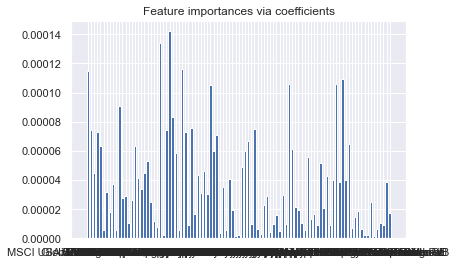

In [230]:
ridge_fit = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(x_train, y_train)
importance = np.abs(ridge_fit.coef_)
feature_names = np.array(x_train.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

### Sequential selection

In [231]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
sfs_forward = SequentialFeatureSelector(
    ridge_fit, n_features_to_select=15, direction="forward"
).fit(x_train, y_train)

In [232]:
feature_names[sfs_forward.get_support()]

array(['S&P 500', 'CDX IG 5Yr', 'CDX HY 5Yr', 'EU IG CDS spread',
       'Min Vol Index', 'IWM',
       'MSCI USA Sector Neutral Quality Index                                                  ',
       'EUR/USD Carry', 'NZD/USD Carry', 'CHF/USD Carry', 'MSCI EM Vol',
       'HY Vol', 'JPM G7 FX Vol',
       'USGG10YR Index                                                  ',
       'USD Libor'], dtype=object)

### Feature selection based on importance

In [233]:
sfm = SelectFromModel(ridge_fit, threshold=np.sort(importance)[-15]).fit(x_train, y_train)
feature_names[sfm.get_support()]

array(['S&P 500', 'MSCI DM', 'CDX HY 5Yr', 'Asian currency',
       'Min Vol Index', 'IWF', 'IWM', 'MSCI USA Momentum Index',
       'MSCI USA Enhanced Value Index', 'JPY/USD Carry', 'CHF/USD Carry',
       'Gold Vol',
       'USGG10YR Index                                                  ',
       'US 10Yr                                            ', 'USD Libor'],
      dtype=object)

## Prophet

In [241]:
from fbprophet import Prophet
selected_vars = feature_names[sfs_forward.get_support()]
m = Prophet(growth = "linear", weekly_seasonality=True, yearly_seasonality=True)
for var in selected_vars:
    m.add_regressor(var)

In [242]:
df_train["Date"] = dates
df_train["value_1d_fwd_rel_ret"] = y_train
df_model = df_train.rename(columns={"Date": "ds", "value_1d_fwd_rel_ret": "y"})

In [243]:
m.fit(df_model)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -41.4682
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5509.73   5.04431e-05       44.8274           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       5509.85   0.000214254       64.4667   2.862e-06       0.001      227  LS failed, Hessian reset 
     179       5509.87   3.35635e-07       40.8809           1           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [244]:
df_test = pd.read_csv(model_data_dir / "test_regression.csv")[["Date", "value_1d_fwd_rel_ret"] + selected_vars.tolist()].rename({"Date": "ds"}, axis=1)


/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


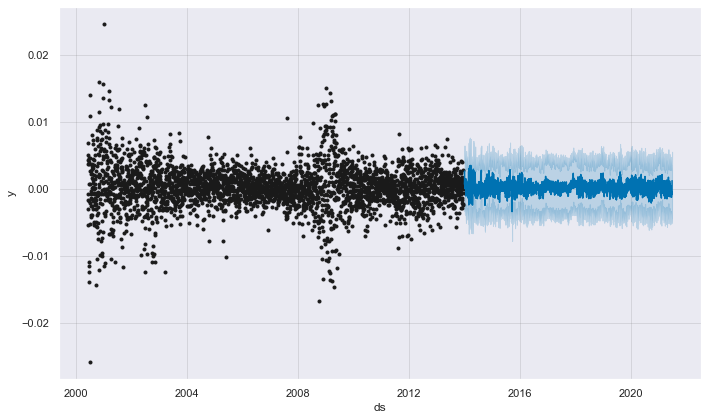

In [245]:
forecast = m.predict(df_test)
fig1 = m.plot(forecast)

<AxesSubplot:xlabel='ds', ylabel='price'>

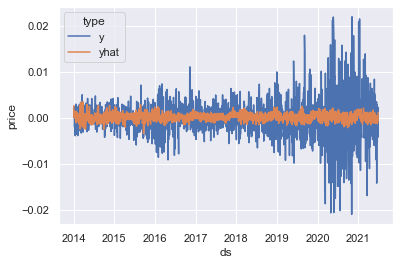

In [254]:
import seaborn as sns
sns.set_theme(style="darkgrid")

df_preds = forecast.assign(y = df_test["value_1d_fwd_rel_ret"])[["ds", "y", "yhat"]]
plot_data = df_preds.melt(id_vars="ds", var_name="type", value_name="price")

# Plot the responses for different events and regions
sns.lineplot(x="ds", y="price",
             hue="type",
             data=plot_data)

/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


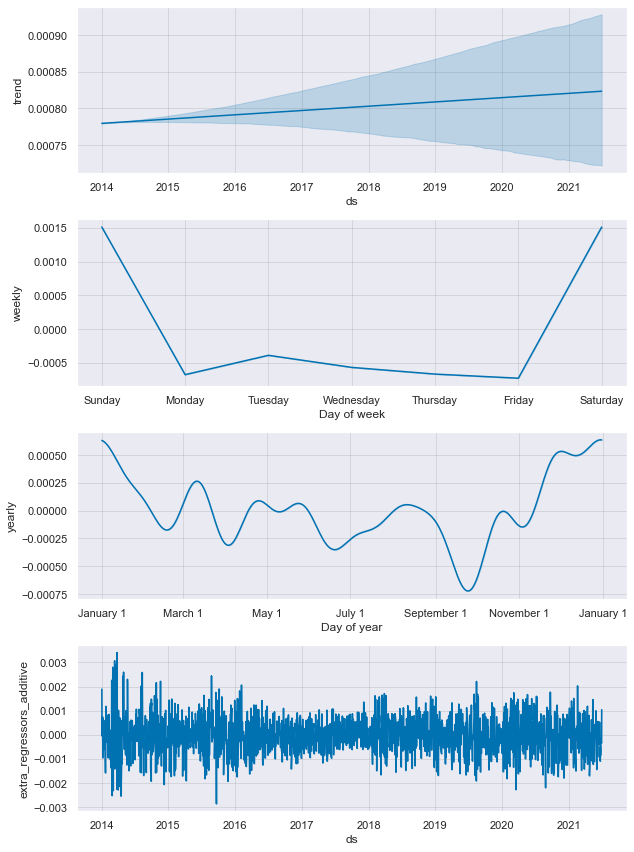

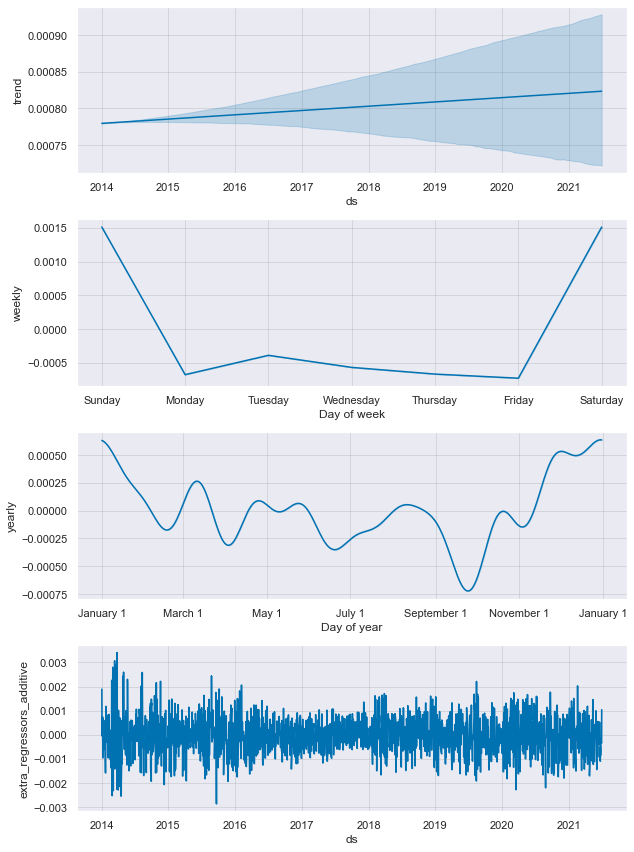

In [247]:
m.plot_components(forecast)

In [256]:
# mean absolute relative error
np.abs((df_preds["y"] - df_preds["yhat"])).mean()

0.0029299156319141473